# Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import pandas as pd
from tabulate import tabulate
from scipy import stats

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import File

In [4]:
# 3. Daftar nama file dan subsektor
subsektors = [
    "Aplikasi", "Arsitektur", "Desain", "Fashion", "Fotografi", "Kriya", "Kuliner",
    "Media", "Musik", "Penerbitan", "Periklanan", "Seni Pertunjukan", "Seni Rupa"
]
base_path = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/01.Subsektor/"

# Perhitungan Nilai ANNi DI

In [5]:
# 3. Fungsi menghitung FI dengan threshold minimal count
def calculate_fii(filepath, min_count=5):
    df = pd.read_excel(filepath)

    # Pastikan kolom numerik
    df['sum'] = pd.to_numeric(df['sum'], errors='coerce')
    df['count'] = pd.to_numeric(df['count'], errors='coerce')
    df['Shape_Area'] = pd.to_numeric(df['Shape_Area'], errors='coerce')

    # Inisialisasi kolom kosong dengan NaN
    df['ANNI'] = np.nan
    df['DI'] = np.nan
    df['NormANNI'] = np.nan
    df['NormDI'] = np.nan
    df['FI_Final'] = np.nan

    # Baris yang valid (count >= min_count)
    valid_idx = df['count'] >= min_count

    # Hitung ANNI dan DI hanya untuk baris valid
    df.loc[valid_idx, 'ANNI'] = (2 * df.loc[valid_idx, 'sum'] / df.loc[valid_idx, 'count']) * \
                                np.sqrt(df.loc[valid_idx, 'count'] / df.loc[valid_idx, 'Shape_Area'])
    df.loc[valid_idx, 'DI'] = df.loc[valid_idx, 'count'] / df.loc[valid_idx, 'Shape_Area']

    # Normalisasi ANNI dan DI hanya untuk baris valid
    if valid_idx.any():
        scaler_anni = MinMaxScaler()
        scaler_di = MinMaxScaler()

        df.loc[valid_idx, 'NormANNI'] = scaler_anni.fit_transform(df.loc[valid_idx, ['ANNI']])
        df.loc[valid_idx, 'NormDI'] = scaler_di.fit_transform(df.loc[valid_idx, ['DI']])

        # Hitung FI_Final dengan bobot 0.3 dan 0.7 (sesuai contoh Anda)
        df.loc[valid_idx, 'FI_Final'] = 0.3 * df.loc[valid_idx, 'NormANNI'] + 0.7 * df.loc[valid_idx, 'NormDI']

    return df


# Gabung Nilai FI

In [6]:
# 4. Fungsi untuk gabung dataframe per subsektor berdasarkan kolom FI_Final
def join_dataframes(dfs, col_names):
    joined = dfs[0].rename(columns={'FI_Final': col_names[0]})
    for i in range(1, len(dfs)):
        joined = pd.merge(
            joined,
            dfs[i].rename(columns={'FI_Final': col_names[i]}),
            on=['OBJECT_ID', 'Desa'],
            how='outer'
        )
    return joined

In [7]:
# 5. Proses semua subsektor
all_data = {}
for name in subsektors:
    file_path = base_path + name + ".xlsx"
    df = calculate_fii(file_path, min_count=5)
    all_data[name] = df

# Perhitungan Nilai CR

In [8]:
# 6. Simpan semua hasil ke Excel
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/01. Hasil FII.xlsx"

with pd.ExcelWriter(output_file) as writer:
    fi_dfs, anni_dfs, di_dfs = [], [], []
    normanni_dfs, normdi_dfs = [], []

    for name in subsektors:
        df = all_data[name]

        # Siapkan dataframe untuk FI, ANNI, DI, NormANNI, NormDI
        fi_dfs.append(df[['OBJECT_ID', 'Desa', 'FI_Final']].rename(columns={'FI_Final': name}))
        anni_dfs.append(df[['OBJECT_ID', 'Desa', 'ANNI']].rename(columns={'ANNI': name}))
        di_dfs.append(df[['OBJECT_ID', 'Desa', 'DI']].rename(columns={'DI': name}))
        normanni_dfs.append(df[['OBJECT_ID', 'Desa', 'NormANNI']].rename(columns={'NormANNI': name}))
        normdi_dfs.append(df[['OBJECT_ID', 'Desa', 'NormDI']].rename(columns={'NormDI': name}))

        # Simpan data per subsektor di sheet terpisah
        df[['OBJECT_ID', 'Desa', 'ANNI', 'DI', 'NormANNI', 'NormDI', 'FI_Final']].to_excel(writer, sheet_name=name, index=False)

    # Gabungkan dataframe per jenis indeks
    fi_result = join_dataframes(fi_dfs, subsektors)
    anni_result = join_dataframes(anni_dfs, subsektors)
    di_result = join_dataframes(di_dfs, subsektors)
    normanni_result = join_dataframes(normanni_dfs, subsektors)
    normdi_result = join_dataframes(normdi_dfs, subsektors)

    # Simpan hasil gabungan
    fi_result.to_excel(writer, sheet_name='FI', index=False)
    anni_result.to_excel(writer, sheet_name='ANNI', index=False)
    di_result.to_excel(writer, sheet_name='DI', index=False)
    normanni_result.to_excel(writer, sheet_name='NormANNI', index=False)
    normdi_result.to_excel(writer, sheet_name='NormDI', index=False)

    # 7. Hitung kontribusi persentase (CR_All)
    joined_dataframe = fi_result.copy()
    for col in subsektors:
        joined_dataframe[col] = pd.to_numeric(joined_dataframe[col], errors='coerce')

    # Hitung total FI per baris (per desa)
    row_sums = joined_dataframe[subsektors].sum(axis=1)

    # Hitung persentase kontribusi subsektor
    for col in subsektors:
        joined_dataframe[col] = (joined_dataframe[col] / row_sums) * 100

    # Ganti NaN dengan 0 (misal jika totalnya 0)
    joined_dataframe = joined_dataframe.fillna(0)

    # Simpan sheet kontribusi
    joined_dataframe.to_excel(writer, sheet_name="CR_All", index=False)

# 8. Print hasil akhir kontribusi
print(joined_dataframe)


     OBJECT_ID          Desa  Aplikasi  Arsitektur  Desain  Fashion  \
0      40178.0     Jangkaran       0.0         0.0     0.0      0.0   
1      40179.0      Sindutan       0.0         0.0     0.0      0.0   
2      40180.0       Palihan       0.0         0.0     0.0      0.0   
3      40181.0        Glagah       0.0         0.0     0.0      0.0   
4      40182.0    Kalidengen       0.0         0.0     0.0      0.0   
..         ...           ...       ...         ...     ...      ...   
435    40613.0  Rejowinangun       0.0         0.0     0.0      0.0   
436    40614.0      Prenggan       0.0         0.0     0.0      0.0   
437    40615.0      Purbayan       0.0         0.0     0.0      0.0   
438        0.0             0       0.0         0.0     0.0      0.0   
439        0.0             0       0.0         0.0     0.0      0.0   

     Fotografi      Kriya     Kuliner  Media  Musik  Penerbitan  Periklanan  \
0          0.0   0.000000    0.000000    0.0    0.0    0.000000     

In [ ]:
# 9. Summary statistik untuk CR_All
summary_cr_all = joined_dataframe[subsektors].describe().T  # Transpose agar subsektor sebagai baris
summary_cr_all = summary_cr_all[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Simpan ke file Excel yang berbeda
summary_output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/02. Summary_cr_all.xlsx"

with pd.ExcelWriter(summary_output_file) as writer:
    summary_cr_all.to_excel(writer, sheet_name='Summary_CR_All', index=True)

# Tampilkan di terminal juga jika ingin
print(summary_cr_all)


                  count       mean        std  min  25%  50%  75%         max
Aplikasi          440.0   0.403191   4.133418  0.0  0.0  0.0  0.0   76.773192
Arsitektur        440.0   0.108911   2.284546  0.0  0.0  0.0  0.0   47.921033
Desain            440.0   0.111173   1.647540  0.0  0.0  0.0  0.0   25.033100
Fashion           440.0   1.252050   7.151647  0.0  0.0  0.0  0.0   74.604071
Fotografi         440.0   1.293621   7.944609  0.0  0.0  0.0  0.0   77.285866
Kriya             440.0   4.541041  18.432449  0.0  0.0  0.0  0.0  100.000000
Kuliner           440.0  16.810792  35.401673  0.0  0.0  0.0  0.0  100.000000
Media             440.0   0.653816   5.986789  0.0  0.0  0.0  0.0  100.000000
Musik             440.0   0.452303   3.468715  0.0  0.0  0.0  0.0   52.719160
Penerbitan        440.0   0.596368   4.972842  0.0  0.0  0.0  0.0   68.084023
Periklanan        440.0   0.583586   5.060566  0.0  0.0  0.0  0.0   53.052178
Seni Pertunjukan  440.0   0.000000   0.000000  0.0  0.0  0.0  0.

# Ringkasan ANNI dan DI

### ANNI DI Boxplot

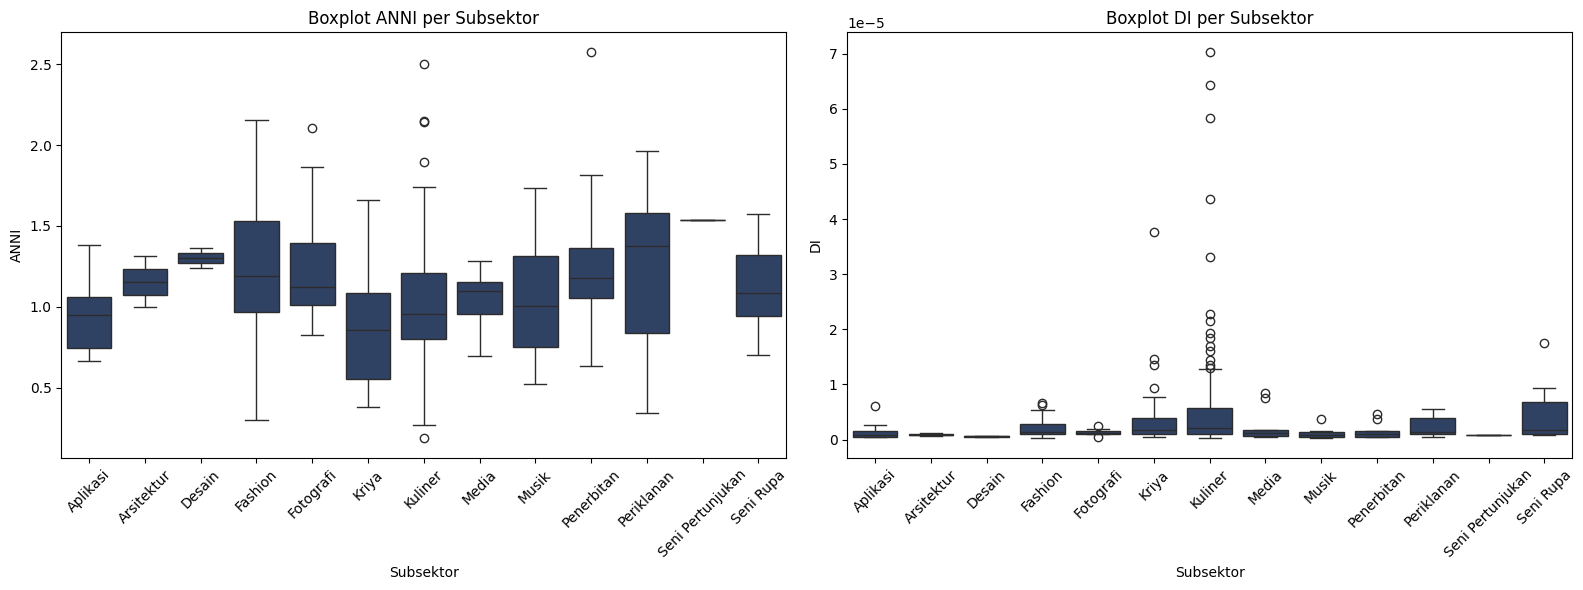

In [ ]:
# 10. Buat Boxplot ANNI dan DI dengan warna khusus
import seaborn as sns

# Siapkan data untuk boxplot ANNI dan DI
anni_long = pd.DataFrame()
di_long = pd.DataFrame()

for name in subsektors:
    anni_temp = all_data[name][['ANNI']].copy()
    anni_temp['Subsektor'] = name
    anni_long = pd.concat([anni_long, anni_temp], ignore_index=True)

    di_temp = all_data[name][['DI']].copy()
    di_temp['Subsektor'] = name
    di_long = pd.concat([di_long, di_temp], ignore_index=True)

# Ukuran figure
plt.figure(figsize=(16, 6))

# Boxplot ANNI
plt.subplot(1, 2, 1)
sns.boxplot(data=anni_long, x='Subsektor', y='ANNI', color='#273f6c')
plt.xticks(rotation=45)
plt.title("Boxplot ANNI per Subsektor")
plt.ylabel("ANNI")
plt.xlabel("Subsektor")

# Boxplot DI
plt.subplot(1, 2, 2)
sns.boxplot(data=di_long, x='Subsektor', y='DI', color='#273f6c')
plt.xticks(rotation=45)
plt.title("Boxplot DI per Subsektor")
plt.ylabel("DI")
plt.xlabel("Subsektor")

# Tampilkan plot
plt.tight_layout()
plt.show()


### Ringkasan Statstik Norm ANNI

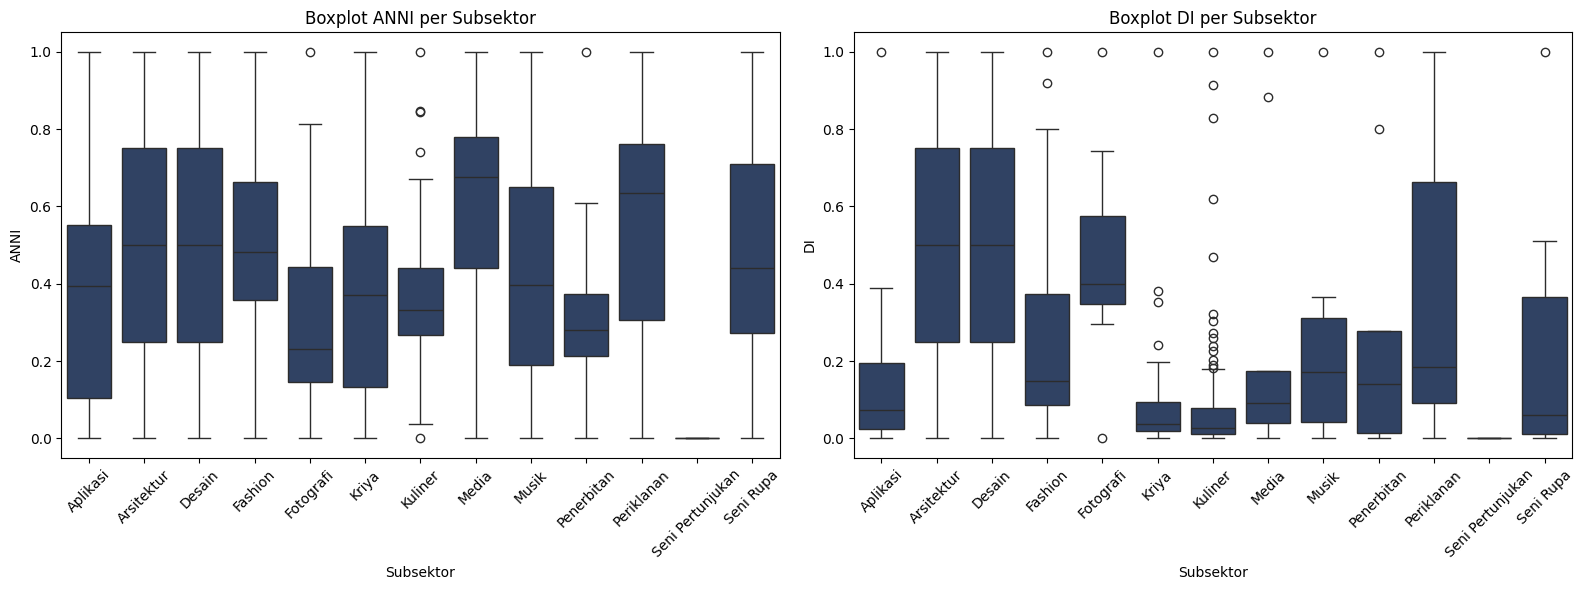

In [ ]:
# 10. Buat Boxplot ANNI dan DI dengan warna khusus
import seaborn as sns

# Siapkan data untuk boxplot ANNI dan DI
anni_long = pd.DataFrame()
di_long = pd.DataFrame()

for name in subsektors:
    anni_temp = all_data[name][['NormANNI']].copy()
    anni_temp['Subsektor'] = name
    anni_long = pd.concat([anni_long, anni_temp], ignore_index=True)

    di_temp = all_data[name][['NormDI']].copy()
    di_temp['Subsektor'] = name
    di_long = pd.concat([di_long, di_temp], ignore_index=True)

# Ukuran figure
plt.figure(figsize=(16, 6))

# Boxplot ANNI
plt.subplot(1, 2, 1)
sns.boxplot(data=anni_long, x='Subsektor', y='NormANNI', color='#273f6c')
plt.xticks(rotation=45)
plt.title("Boxplot ANNI per Subsektor")
plt.ylabel("ANNI")
plt.xlabel("Subsektor")

# Boxplot DI
plt.subplot(1, 2, 2)
sns.boxplot(data=di_long, x='Subsektor', y='NormDI', color='#273f6c')
plt.xticks(rotation=45)
plt.title("Boxplot DI per Subsektor")
plt.ylabel("DI")
plt.xlabel("Subsektor")

# Tampilkan plot
plt.tight_layout()
plt.show()


### Ringkasan Statistik ANNI

In [ ]:
anni_summary = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    anni_series = df['ANNI'].dropna()

    summary = {
        'Subsektor': name,
        'Min': round(anni_series.min(), 5),
        'Q1': round(anni_series.quantile(0.25), 5),
        'Median': round(anni_series.median(), 5),
        'Q3': round(anni_series.quantile(0.75), 5),
        'Max': round(anni_series.max(), 5),
        'Mean': round(anni_series.mean(), 5)
    }

    anni_summary.append(summary)

# Membuat DataFrame dari summary
anni_summary_df = pd.DataFrame(anni_summary)

# Menampilkan tabel dengan garis
print(anni_summary_df.to_markdown(index=False))

# Simpan ke file Excel
output_file ="/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/03. Output_anni_summary.xlsx"  # ganti nama jika perlu

anni_summary_df.to_excel(output_file, sheet_name='ANNI_Summary', index=False)
print(f"Hasil summary ANNI telah disimpan ke dalam file: {output_file}")


| Subsektor        |     Min |      Q1 |   Median |      Q3 |     Max |    Mean |
|:-----------------|--------:|--------:|---------:|--------:|--------:|--------:|
| Aplikasi         | 0.6668  | 0.74227 |  0.94845 | 1.06106 | 1.38006 | 0.95342 |
| Arsitektur       | 0.99576 | 1.07581 |  1.15587 | 1.23593 | 1.31599 | 1.15587 |
| Desain           | 1.23982 | 1.27029 |  1.30076 | 1.33123 | 1.3617  | 1.30076 |
| Fashion          | 0.29924 | 0.96489 |  1.19187 | 1.53104 | 2.15361 | 1.24358 |
| Fotografi        | 0.82738 | 1.01288 |  1.12308 | 1.39401 | 2.10383 | 1.26775 |
| Kriya            | 0.37965 | 0.55154 |  0.85516 | 1.08587 | 1.66284 | 0.86862 |
| Kuliner          | 0.18547 | 0.80377 |  0.95503 | 1.20705 | 2.50192 | 1.02232 |
| Media            | 0.69539 | 0.95562 |  1.09476 | 1.15576 | 1.28534 | 1.04766 |
| Musik            | 0.52011 | 0.75123 |  1.0033  | 1.31093 | 1.73485 | 1.03899 |
| Penerbitan       | 0.63611 | 1.05149 |  1.17832 | 1.36136 | 2.57752 | 1.32438 |
| Periklanan    

In [ ]:
anni_summary = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    anni_series = df['ANNI'].dropna()

    # Menentukan index desa ANNI minimum dan maksimum
    min_idx = anni_series.idxmin()
    max_idx = anni_series.idxmax()

    # Mengambil nama desa dan jumlah titik (count)
    desa_min = df.loc[min_idx, 'Desa']
    desa_max = df.loc[max_idx, 'Desa']
    titik_desa_min = df.loc[min_idx, 'count']
    titik_desa_max = df.loc[max_idx, 'count']

    # Menjumlahkan total titik di seluruh desa dalam subsektor
    total_titik = df['count'].sum()

    summary = {
        'Subsektor': name,
        'Total_Titik': int(total_titik),
        'Min': round(anni_series.min(), 5),
        'Q1': round(anni_series.quantile(0.25), 5),
        'Median': round(anni_series.median(), 5),
        'Q3': round(anni_series.quantile(0.75), 5),
        'Max': round(anni_series.max(), 5),
        'Mean': round(anni_series.mean(), 5),
        'Desa_Min': desa_min,
        'Titik_Desa_Min': int(titik_desa_min),
        'Desa_Max': desa_max,
        'Titik_Desa_Max': int(titik_desa_max)
    }

    anni_summary.append(summary)

# Membuat DataFrame dari summary
anni_summary_df = pd.DataFrame(anni_summary)

# Menampilkan tabel dengan garis
print(anni_summary_df.to_markdown(index=False))

# Simpan ke file Excel
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/03. Output_anni_summary-2.xlsx"

anni_summary_df.to_excel(output_file, sheet_name='ANNI_Summary', index=False)
print(f"Hasil summary ANNI telah disimpan ke dalam file: {output_file}")


| Subsektor        |   Total_Titik |     Min |      Q1 |   Median |      Q3 |     Max |    Mean | Desa_Min      |   Titik_Desa_Min | Desa_Max         |   Titik_Desa_Max |
|:-----------------|--------------:|--------:|--------:|---------:|--------:|--------:|--------:|:--------------|-----------------:|:-----------------|-----------------:|
| Aplikasi         |           203 | 0.6668  | 0.74227 |  0.94845 | 1.06106 | 1.38006 | 0.95342 | Wedomartani   |                7 | Purwomartani     |                5 |
| Arsitektur       |           147 | 0.99576 | 1.07581 |  1.15587 | 1.23593 | 1.31599 | 1.15587 | Wedomartani   |                9 | Sinduharjo       |                7 |
| Desain           |           118 | 1.23982 | 1.27029 |  1.30076 | 1.33123 | 1.3617  | 1.30076 | Condongcatur  |                6 | Purwomartani     |                6 |
| Fashion          |           748 | 0.29924 | 0.96489 |  1.19187 | 1.53104 | 2.15361 | 1.24358 | Panembahan    |                5 | Pendowoharjo

### Ringkasan Statistik FI

In [ ]:

FI_Final_summary = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    anni_series = df['FI_Final'].dropna()

    summary = {
        'Subsektor': name,
        'Min': round(anni_series.min(), 10),
        'Q1': round(anni_series.quantile(0.25), 10),
        'Median': round(anni_series.median(), 10),
        'Q3': round(anni_series.quantile(0.75), 10),
        'Max': round(anni_series.max(), 10),
        'Mean': round(anni_series.mean(), 10)
    }

    FI_Final_summary.append(summary)

# Membuat DataFrame dari summary
FI_Final_summary_df = pd.DataFrame(FI_Final_summary)

# Menampilkan tabel dengan garis
print(FI_Final_summary_df.to_markdown(index=False))

# Simpan ke file Excel
output_file ="/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/04. Output_FI_Final_summary.xlsx"  # ganti nama jika perlu

FI_Final_summary_df.to_excel(output_file, sheet_name='FI_Final_summary', index=False)
print(f"Hasil summary ANNI telah disimpan ke dalam file: {output_file}")


| Subsektor        |        Min |       Q1 |   Median |       Q3 |      Max |     Mean |
|:-----------------|-----------:|---------:|---------:|---------:|---------:|---------:|
| Aplikasi         | 0.018059   | 0.151005 | 0.218133 | 0.305224 | 0.806805 | 0.263292 |
| Arsitektur       | 0          | 0.25     | 0.5      | 0.75     | 1        | 0.5      |
| Desain           | 0.3        | 0.4      | 0.5      | 0.6      | 0.7      | 0.5      |
| Fashion          | 0.122043   | 0.19868  | 0.275065 | 0.390315 | 0.930521 | 0.353032 |
| Fotografi        | 0.111287   | 0.348351 | 0.415061 | 0.505116 | 0.71138  | 0.427528 |
| Kriya            | 0.00503824 | 0.10065  | 0.151302 | 0.24898  | 0.867143 | 0.184645 |
| Kuliner          | 0          | 0.103375 | 0.14112  | 0.206895 | 0.740904 | 0.17223  |
| Media            | 0.102168   | 0.255295 | 0.288157 | 0.351249 | 0.900944 | 0.366372 |
| Musik            | 0.0539022  | 0.218068 | 0.260939 | 0.387043 | 0.7      | 0.298758 |
| Penerbitan       | 

In [ ]:
anni_summary_norm = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    anni_series_norm = df['NormANNI'].dropna()

    summary = {
        'Subsektor': name,
        'Min': round(anni_series_norm.min(), 5),
        'Q1': round(anni_series_norm.quantile(0.25), 5),
        'Median': round(anni_series_norm.median(), 5),
        'Q3': round(anni_series_norm.quantile(0.75), 5),
        'Max': round(anni_series_norm.max(), 5),
        'Mean': round(anni_series_norm.mean(), 5)
    }

    anni_summary_norm.append(summary)

# Membuat DataFrame dari summary
anni_summary_norm_df = pd.DataFrame(anni_summary_norm)

# Menampilkan tabel dengan garis
print(anni_summary_norm_df.to_markdown(index=False))

# Simpan ke file Excel
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/05. Output_anni_summary_norm.xlsx"

anni_summary_norm_df.to_excel(output_file, sheet_name='ANNI_Summary', index=False)
print(f"Hasil summary ANNI telah disimpan ke dalam file: {output_file}")


| Subsektor        |   Min |      Q1 |   Median |      Q3 |   Max |    Mean |
|:-----------------|------:|--------:|---------:|--------:|------:|--------:|
| Aplikasi         |     0 | 0.10582 |  0.39488 | 0.55276 |     1 | 0.40185 |
| Arsitektur       |     0 | 0.25    |  0.5     | 0.75    |     1 | 0.5     |
| Desain           |     0 | 0.25    |  0.5     | 0.75    |     1 | 0.5     |
| Fashion          |     0 | 0.35897 |  0.48137 | 0.66427 |     1 | 0.50925 |
| Fotografi        |     0 | 0.14532 |  0.23166 | 0.44391 |     1 | 0.345   |
| Kriya            |     0 | 0.13396 |  0.37057 | 0.55036 |     1 | 0.38105 |
| Kuliner          |     0 | 0.26692 |  0.33222 | 0.44101 |     1 | 0.36126 |
| Media            |     0 | 0.44112 |  0.67696 | 0.78035 |     1 | 0.59713 |
| Musik            |     0 | 0.19027 |  0.39777 | 0.65102 |     1 | 0.42715 |
| Penerbitan       |     0 | 0.21396 |  0.27929 | 0.37357 |     1 | 0.35452 |
| Periklanan       |     0 | 0.30694 |  0.6358  | 0.76152 |     

### Ringkasan Statistik DI

In [ ]:
di_summary = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    di_series = df['DI'].dropna()

    summary = {
        'Subsektor': name,
        'Minimum': round(di_series.min(), 10),
        'Kuartil 1': round(di_series.quantile(0.25), 10),
        'Median': round(di_series.median(), 10),
        'Kuartil 3': round(di_series.quantile(0.75), 10),
        'Maksimum': round(di_series.max(), 10),
        'Rata-rata': round(di_series.mean(),10)
    }

    di_summary.append(summary)

# Membuat DataFrame dari summary
di_summary_df = pd.DataFrame(di_summary)

# Menampilkan tabel dengan garis (markdown)
print(di_summary_df.to_markdown(index=False))

# Simpan ke file Excel
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/06. Output_di_summary.xlsx"  # ganti nama jika perlu

di_summary_df.to_excel(output_file, sheet_name='di_Summary', index=False)
print(f"Hasil summary ANNI telah disimpan ke dalam file: {output_file}")

| Subsektor        |   Minimum |   Kuartil 1 |     Median |   Kuartil 3 |    Maksimum |   Rata-rata |
|:-----------------|----------:|------------:|-----------:|------------:|------------:|------------:|
| Aplikasi         | 3.904e-07 |  5.379e-07  | 8.176e-07  |  1.5117e-06 | 6.1071e-06  |  1.5561e-06 |
| Arsitektur       | 6.916e-07 |  8.11e-07   | 9.304e-07  |  1.0499e-06 | 1.1693e-06  |  9.304e-07  |
| Desain           | 5.197e-07 |  5.599e-07  | 6.001e-07  |  6.403e-07  | 6.805e-07   |  6.001e-07  |
| Fashion          | 3.842e-07 |  9.335e-07  | 1.3238e-06 |  2.7487e-06 | 6.7119e-06  |  2.1944e-06 |
| Fotografi        | 3.904e-07 |  1.1073e-06 | 1.2162e-06 |  1.5804e-06 | 2.4583e-06  |  1.3476e-06 |
| Kriya            | 3.895e-07 |  1.0621e-06 | 1.8224e-06 |  3.8785e-06 | 3.75633e-05 |  4.1244e-06 |
| Kuliner          | 2.079e-07 |  1.0089e-06 | 2.0341e-06 |  5.7219e-06 | 7.03505e-05 |  6.606e-06  |
| Media            | 3.904e-07 |  7.097e-07  | 1.1342e-06 |  1.7951e-06 | 8.4584e-

In [ ]:
di_summary = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    di_series = df['DI'].dropna()

    # Index untuk nilai minimum dan maksimum
    min_idx = di_series.idxmin()
    max_idx = di_series.idxmax()

    # Informasi nama desa dan jumlah titik
    desa_min = df.loc[min_idx, 'Desa']
    desa_max = df.loc[max_idx, 'Desa']
    titik_desa_min = df.loc[min_idx, 'count']
    titik_desa_max = df.loc[max_idx, 'count']

    # Total jumlah titik dalam subsektor
    total_titik = df['count'].sum()

    summary = {
        'Subsektor': name,
        'Total_Titik': int(total_titik),
        'Minimum': round(di_series.min(), 10),
        'Kuartil 1': round(di_series.quantile(0.25), 10),
        'Median': round(di_series.median(), 10),
        'Kuartil 3': round(di_series.quantile(0.75), 10),
        'Maksimum': round(di_series.max(), 10),
        'Rata-rata': round(di_series.mean(), 10),
        'Desa_Min': desa_min,
        'Titik_Desa_Min': int(titik_desa_min),
        'Desa_Max': desa_max,
        'Titik_Desa_Max': int(titik_desa_max)
    }

    di_summary.append(summary)

# Membuat DataFrame dari summary
di_summary_df = pd.DataFrame(di_summary)

# Menampilkan tabel dengan format markdown
print(di_summary_df.to_markdown(index=False))

# Simpan ke file Excel
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/06. Output_di_summary-2.xlsx"
di_summary_df.to_excel(output_file, sheet_name='DI_Summary', index=False)

print(f"Hasil summary DI telah disimpan ke dalam file: {output_file}")


| Subsektor        |   Total_Titik |   Minimum |   Kuartil 1 |     Median |   Kuartil 3 |    Maksimum |   Rata-rata | Desa_Min      |   Titik_Desa_Min | Desa_Max         |   Titik_Desa_Max |
|:-----------------|--------------:|----------:|------------:|-----------:|------------:|------------:|------------:|:--------------|-----------------:|:-----------------|-----------------:|
| Aplikasi         |           203 | 3.904e-07 |  5.379e-07  | 8.176e-07  |  1.5117e-06 | 6.1071e-06  |  1.5561e-06 | Maguwoharjo   |                6 | Terban           |                5 |
| Arsitektur       |           147 | 6.916e-07 |  8.11e-07   | 9.304e-07  |  1.0499e-06 | 1.1693e-06  |  9.304e-07  | Wedomartani   |                9 | Sinduharjo       |                7 |
| Desain           |           118 | 5.197e-07 |  5.599e-07  | 6.001e-07  |  6.403e-07  | 6.805e-07   |  6.001e-07  | Purwomartani  |                6 | Condongcatur     |                6 |
| Fashion          |           748 | 3.842e-0

### Ringkasan Statistik Norm DI

In [ ]:
di_summary_norm = []

# Menghitung summary untuk setiap subsektor
for name in subsektors:
    df = all_data[name]
    di_series = df['NormDI'].dropna()

    summary = {
        'Subsektor': name,
        'Minimum': round(di_series.min(), 5),
        'Kuartil 1': round(di_series.quantile(0.25), 5),
        'Median': round(di_series.median(), 5),
        'Kuartil 3': round(di_series.quantile(0.75), 5),
        'Maksimum': round(di_series.max(), 5),
        'Rata-rata': round(di_series.mean(), 5)
    }

    di_summary_norm.append(summary)

# Membuat DataFrame dari summary
di_summary_norm_df = pd.DataFrame(di_summary_norm)

# Menampilkan tabel dengan garis (markdown)
print(di_summary_norm_df.to_markdown(index=False))

# Simpan ke file Excel
output_file ="/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/07. Output_di_summary_norm.xlsx"

di_summary_norm_df.to_excel(output_file, sheet_name='DI_Summary', index=False)
print(f"Hasil summary NormDI telah disimpan ke dalam file: {output_file}")


| Subsektor        |   Minimum |   Kuartil 1 |   Median |   Kuartil 3 |   Maksimum |   Rata-rata |
|:-----------------|----------:|------------:|---------:|------------:|-----------:|------------:|
| Aplikasi         |         0 |     0.0258  |  0.07472 |     0.19614 |          1 |     0.20391 |
| Arsitektur       |         0 |     0.25    |  0.5     |     0.75    |          1 |     0.5     |
| Desain           |         0 |     0.25    |  0.5     |     0.75    |          1 |     0.5     |
| Fashion          |         0 |     0.0868  |  0.14849 |     0.37368 |          1 |     0.28608 |
| Fotografi        |         0 |     0.34669 |  0.39935 |     0.57547 |          1 |     0.4629  |
| Kriya            |         0 |     0.01809 |  0.03855 |     0.09386 |          1 |     0.10047 |
| Kuliner          |         0 |     0.01142 |  0.02604 |     0.07861 |          1 |     0.09122 |
| Media            |         0 |     0.03957 |  0.0922  |     0.17411 |          1 |     0.26748 |
| Musik   

# Uji Grubs

In [9]:
import pandas as pd
import numpy as np
from scipy import stats

# Fungsi untuk melakukan Uji Grubbs
def grubbs_test(values, alpha=0.05):
    values = np.array(values)
    n = len(values)
    mean_value = np.mean(values)
    std_dev = np.std(values, ddof=1)  # Sample standard deviation

    if std_dev == 0 or np.isnan(std_dev):
        return None  # Tidak bisa uji Grubbs jika deviasi nol atau NaN

    max_dev = np.max(np.abs(values - mean_value))
    G = max_dev / std_dev

    # Hitung nilai kritis G
    t_critical = stats.t.ppf(1 - alpha / (2 * n), df=n - 2)
    G_critical = ((n - 1) / np.sqrt(n)) * np.sqrt(t_critical**2 / (n - 2 + t_critical**2))

    if G > G_critical:
        outlier_index = np.argmax(np.abs(values - mean_value))
        return values[outlier_index]
    else:
        return None

# Fungsi untuk memeriksa apakah ada outlier atau nilai di atas rata-rata per baris
def check_outliers(row):
    row_values = row.iloc[2:].astype(float)  # Ambil nilai numerik (mulai kolom ke-3)
    column_names = row.index[2:]

    outlier_value = grubbs_test(row_values, alpha=0.05)

    if outlier_value is not None:
        outlier_column = column_names[np.where(row_values == outlier_value)[0][0]]
        return f"Outlier: {outlier_value:.4f} in column {outlier_column}"
    else:
        mean_value = row_values.mean()
        above_mean_columns = column_names[row_values > mean_value]
        if len(above_mean_columns) > 0:
            return f"Above Mean: {', '.join(above_mean_columns)}"
        else:
            return "No outliers or values above mean"

# === Langkah Utama ===

# 1. Baca file Excel dari sheet CR_All
input_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/01. Hasil FII.xlsx"
df_fi_all = pd.read_excel(input_file, sheet_name="CR_All")

# 2. Terapkan fungsi uji Grubbs dan pengecekan per baris
df_fi_all['Result'] = df_fi_all.apply(check_outliers, axis=1)

# 3. Simpan ke file Excel baru dalam sheet "Uji Grubbs"
output_file = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/02. Hasil Uji Grubbs.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_fi_all.to_excel(writer, sheet_name='Uji Grubbs', index=False)

print("✅ Hasil uji Grubbs berhasil disimpan ke file baru pada sheet 'Uji Grubbs'.")


✅ Hasil uji Grubbs berhasil disimpan ke file baru pada sheet 'Uji Grubbs'.


In [10]:
import pandas as pd

# Path file input dan output
input_file_path = "/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/00.Rekap.xlsx"
output_file_path ="/content/drive/MyDrive/03. Bismillah Skripsi/00. Sidang/02. Function Intensity Index/02. Hasil Uji Grubbs.xlsx"

# Baca data dari sheet pertama di file input
df = pd.read_excel(input_file_path)

# Filter data: kolom C sampai O harus memiliki nilai >= 5
filtered_df = df.loc[(df.iloc[:, 2:15] >= 5).any(axis=1), ['OBJECT_ID', 'Desa'] + df.columns[2:15].tolist()]

# Menulis data yang difilter ke dalam sheet 'Desa IKM' di file output
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    filtered_df.to_excel(writer, sheet_name='Desa IKM', index=False)

print("Data berhasil disimpan dalam sheet 'Desa IKM'.")

Data berhasil disimpan dalam sheet 'Desa IKM'.


In [11]:
import pandas as pd
from IPython.display import display

# Baca data dari sheet 'Desa IKMM2' untuk mendapatkan desa yang relevan
df_desa_ikm = pd.read_excel(output_file_path, sheet_name='Desa IKM')

# Baca data dari sheet 'Uji Grubbs'
df_uji_grubbs = pd.read_excel(output_file_path, sheet_name='Uji Grubbs')

# Filter data dari sheet 'Uji Grubbs' yang sesuai dengan desa di sheet 'Desa IKMM2'
filtered_uji_grubbs = df_uji_grubbs[df_uji_grubbs['OBJECT_ID'].isin(df_desa_ikm['OBJECT_ID'])]

# Fungsi untuk mengekstrak informasi dari hasil 'Result'
def extract_info(outlier_text):
    outlier_part = ""
    above_mean_part = ""

    if "Outlier:" in outlier_text:
        outlier_part = outlier_text.split(" in column ")[-1].strip()
    if "Above Mean:" in outlier_text:
        above_mean_part = outlier_text.split("Above Mean:")[-1].strip()

    return f"{outlier_part} {above_mean_part}".strip()

# Tambahkan kolom 'Keterangan' dengan hasil ekstraksi informasi
filtered_uji_grubbs['Keterangan'] = filtered_uji_grubbs['Result'].apply(extract_info)

# Tampilkan data yang sudah difilter dan kolom 'Keterangan' dalam bentuk tabel yang rapi
display(filtered_uji_grubbs)


/tmp/ipython-input-1209378903.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_uji_grubbs['Keterangan'] = filtered_uji_grubbs['Result'].apply(extract_info)


,OBJECT_ID,Desa,Aplikasi,Arsitektur,Desain,Fashion,Fotografi,Kriya,Kuliner,Media,Musik,Penerbitan,Periklanan,Seni Pertunjukan,Seni Rupa,Result,Keterangan
3,40181,Glagah,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kuliner,Kuliner
20,40198,Bendungan,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kuliner,Kuliner
22,40200,Giripeni,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kuliner,Kuliner
46,40224,Ngentakrejo,0.0,0.0,0.0,0.0,0.0,100.000000,0.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kriya,Kriya
53,40231,Sentolo,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kuliner,Kuliner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,40611,Sorosutan,0.0,0.0,0.0,0.0,0.0,67.274256,32.725744,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 67.2743 in column Kriya,Kriya
434,40612,Giwangan,0.0,0.0,0.0,0.0,0.0,100.000000,0.000000,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 100.0000 in column Kriya,Kriya
435,40613,Rejowinangun,0.0,0.0,0.0,0.0,0.0,15.161676,16.754301,0.0,0.0,68.084023,0.0,0,0.0,Outlier: 68.0840 in column Penerbitan,Penerbitan
436,40614,Prenggan,0.0,0.0,0.0,0.0,0.0,62.429343,37.570657,0.0,0.0,0.000000,0.0,0,0.0,Outlier: 62.4293 in column Kriya,Kriya


In [12]:

# Simpan hasil di sheet 'Sentra IKM' dalam file Excel yang sama
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    filtered_uji_grubbs.to_excel(writer, sheet_name='Sentra IKM', index=False)

print("Data berhasil disimpan dalam sheet 'Sentra IKM'.")

Data berhasil disimpan dalam sheet 'Sentra IKM'.
